In [1]:
import os
api_key=os.getenv("OPENAI_API_KEY")
f"{api_key}"

'euri-4f0602430b4d9f104e1a21d375f893ba06fa5b0d9b32844abd5d64202f493a7b'

In [2]:
import requests
from dotenv import load_dotenv
import os
load_dotenv()
api_key=os.getenv('OPENAI_API_KEY')

url = "https://api.euron.one/api/v1/euri/embeddings"
headers = {
    "Content-Type": "application/json",
    "Authorization": b"Bearer euri-4f0602430b4d9f104e1a21d375f893ba06fa5b0d9b32844abd5d64202f493a7b"
}

payload = {
    "input": ["hello world", "machine learning is cool"],
    "model": "text-embedding-3-small"
}

response = requests.post(url, headers=headers, json=payload)
print("Status:", response.status_code)
print("Response:", response.text)


Status: 200
Response: {"object":"list","data":[{"object":"embedding","embedding":[-0.006763331,-0.03919632,0.034175806,0.028762115,-0.02478502,-0.042039264,-0.030289441,0.049328085,-0.013897153,-0.017647417,0.015363989,-0.027038202,-0.020974265,-0.027854793,0.008619561,0.035627518,-0.053683233,-0.002272086,0.008808587,0.047997344,0.03710948,-0.009247126,-0.008778343,0.0114020165,0.014078617,-0.0021624514,-0.03756314,0.0454266,0.011250796,-0.039649982,0.02345428,-0.05062858,0.012044703,-0.000015505995,0.01602936,0.0061357664,0.031967986,0.0033608729,-0.008604439,-0.010555182,-0.037381675,-0.03450849,0.049993455,0.019371329,-0.014275203,0.015265697,-0.054348603,0.050416872,0.0454266,0.053713474,-0.0015405576,0.018524496,0.03556703,0.115955785,-0.013262027,-0.04092023,0.013383003,0.047694907,-0.014948133,0.024679165,0.032179695,0.01336032,0.017027413,0.024845507,0.013383003,0.008990051,-0.024361601,-0.00039435437,-0.00064457685,0.053864695,-0.0025140387,0.037744604,-0.01870596,-0.01150787

In [3]:
pwd

'e:\\GENAI\\clinical-rag\\notebooks'

In [4]:
cd ..

e:\GENAI\clinical-rag


c:\Users\santh\anaconda3\envs\rag\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
from langchain_community.document_loaders import DirectoryLoader,PyPDFLoader,DirectoryLoader
from pathlib import Path
data_dir = "data/HealthCareSectorinindia-AnOverview.pdf"

dir_loader=PyPDFLoader(file_path=data_dir)
# pdf_loader = DirectoryLoader(
#             data_dir,
#             glob="**/*.pdf",
#             loader_cls=PyPDFLoader
#         )


In [4]:
dir_loader.load()

[Document(page_content="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled : International issues on Health Economics \nand Management \nEdited By : Dr. Arulraj \nPublished  by : \nTISSL International Publications,  \nNew Delhi, India \nYear of Publication : 2010 \nPages in which this article appears : 215-218 \nISBN No. : 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHealth is defined as a state of complete 

In [36]:
import fitz  # pymupdf
import pytesseract
from PIL import Image
import io
import matplotlib.pyplot as plt

def extract_text_from_pdf_images(pdf_path: str) -> str:
    """
    Extract images from PDF pages and run OCR on them
    """
    text = ""

    doc = fitz.open(pdf_path)

    for page_num in range(len(doc)):
        page = doc[page_num]

        image_list = page.get_images(full=True)
        print(image_list)

        for img_index, img in enumerate(image_list):

            xref = img[0]
            base_image = doc.extract_image(xref)

            image_bytes = base_image["image"]

            image = Image.open(io.BytesIO(image_bytes))
            plt.imshow(image)
            text += pytesseract.image_to_string(image)

    return text.strip()


In [39]:
import uuid
from typing import List

from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader, TextLoader, UnstructuredWordDocumentLoader,UnstructuredImageLoader

from app.dataclasses import RawDocument

class DocumentLoader:

    def __init__(self, folder_path: str):
        self.folder_path = folder_path

    def load(self) -> List[RawDocument]:

        docs = []

        # 1. Normal PDF TEXT
        pdf_loader = DirectoryLoader(
            self.folder_path,
            glob="**/*.pdf",
            loader_cls=PyPDFLoader
        )

        for lc_doc in pdf_loader.load():
            text = lc_doc.page_content

            # 2. OCR on images inside same PDF
            source = lc_doc.metadata.get("source")

            if source:
                pdf_path = f"{source}"
                image_text = extract_text_from_pdf_images(pdf_path)

                # Combine them
                text = text + "\n" + image_text

            docs.append(
                RawDocument(
                    id=str(uuid.uuid4()),
                    text=text,
                    metadata=lc_doc.metadata
                )
            )

        # 3. Other file types
        other_loaders = [
            DirectoryLoader(self.folder_path, glob="**/*.txt", loader_cls=TextLoader),
            DirectoryLoader(self.folder_path, glob="**/*.docx", loader_cls=UnstructuredWordDocumentLoader),
            DirectoryLoader(
                self.folder_path,
                glob="**/*.[pj][pn]g",
                loader_cls=UnstructuredImageLoader 
            )
        ]

        for loader in other_loaders:
            for lc_doc in loader.load():
                docs.append(
                    RawDocument(
                        id=str(uuid.uuid4()),
                        text=lc_doc.page_content,
                        metadata=lc_doc.metadata
                    )
                )

        return docs

doc_loader=DocumentLoader("data")


In [1]:
import pytesseract
print(pytesseract.get_tesseract_version())


5.5.0.20241111


In [50]:
import pandas as pd
df = pd.DataFrame({
    'A': [10, 20, 30],
    'B': ["tamil", 50, 60],
    'C': [70, 80, 90]
})
print(df)
# Get the first row as a Series
first_row_series = df.head(1).squeeze()

print(first_row_series[0])
print(first_row_series[1])

# print(type(first_row_series))

    A      B   C
0  10  tamil  70
1  20     50  80
2  30     60  90
10
tamil


C:\Users\santh\AppData\Local\Temp\ipykernel_97596\1933051957.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(first_row_series[0])
C:\Users\santh\AppData\Local\Temp\ipykernel_97596\1933051957.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(first_row_series[1])


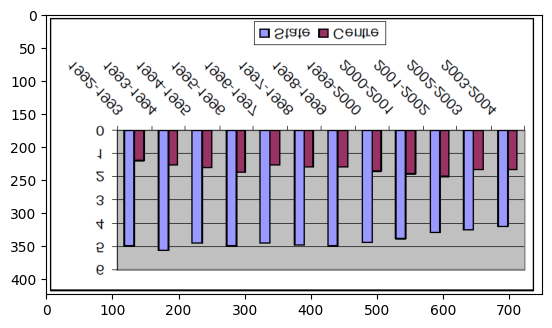

In [24]:
pdf_path = "data/HealthCareSectorinindia-AnOverview.pdf"   # <-- change to your real PDF name
image_text = extract_text_from_pdf_images(pdf_path)

In [26]:
docs

[RawDocument(id='ed970201-e59c-439c-9b89-81b9eb73d0e0', text="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled : International issues on Health Economics \nand Management \nEdited By : Dr. Arulraj \nPublished  by : \nTISSL International Publications,  \nNew Delhi, India \nYear of Publication : 2010 \nPages in which this article appears : 215-218 \nISBN No. : 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHea

In [27]:
keyword="The government expenditure"
if keyword.lower() in image_text.lower():
    print(image_text)

In [30]:
from langchain_community.document_loaders import PyMuPDFLoader

mupdf=PyMuPDFLoader(file_path=pdf_path)

In [33]:
mupdf.load()

[Document(page_content="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled \n: International issues on Health Economics \nand Management \nEdited By \n: Dr. Arulraj \nPublished  by \n: TISSL \nInternational \nPublications, \nNew Delhi, India \nYear of Publication \n: 2010 \nPages in which this article appears \n: 215-218 \nISBN No. \n: 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHealth is defined as a state

In [41]:
pip install rapidocr-onnxruntime

  Using cached pyclipper-1.3.0.post6-cp310-cp310-win_amd64.whl.metadata (9.2 kB)
  Using cached shapely-2.1.2-cp310-cp310-win_amd64.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.9 MB ? eta -:--:--
   -- ------------------------------------- 1.0/14.9 MB 5.0 MB/s eta 0:00:03
   ------ --------------------------------- 2.4/14.9 MB 5.6 MB/s eta 0:00:03
   ---------- ----------------------------- 3.9/14.9 MB 6.2 MB/s eta 0:00:02
   ------------- -------------------------- 5.0/14.9 MB 6.2 MB/s eta 0:00:02
   --------------- ------------------------ 5.8/14.9 MB 5.6 MB/s eta 0:00:02
   ------------------ --------------------- 6.8/14.9 MB 5.3 MB/s eta 0:00:02
   --------------------- ------------------ 7.9/14.9 MB 5.4 MB/s eta 0:00:02
   ---------------------- ----------------- 8.4/14.9 MB 5.4 MB/s eta 0:00:02
   ---------------------- ----------------- 8.4/14.9 MB 5.4 MB/s eta 0:00:02
   ----------

In [ ]:
pdf=PyPDFLoader(file_path=pdf_path,extract_images=True)
pdf.load()

[Document(page_content="Health Care System in India : An Overview \nA. Sheeba ∗ \n   Dr. A. Seilan ∗∗ \nThis article published in the edited book titled : International issues on Health Economics \nand Management \nEdited By : Dr. Arulraj \nPublished  by : \nTISSL International Publications,  \nNew Delhi, India \nYear of Publication : 2010 \nPages in which this article appears : 215-218 \nISBN No. : 978-93-80449-15-9 \n \nHealth care is the prevention, treatment, and management of illness and the preservation of \nmental and physical well being through the services offered by the medical, nursing, and allied health \nprofessions. According to the World Health Organisation, health care embraces all the goods and \nservices designed to promote health, including “preventive, curative and palliative interventions, \nwhether directed to individuals or to populations”. The organised provision of such services may \nconstitute a health care system.  \nHealth is defined as a state of complete 

In [2]:
from rank_bm25 import BM25Okapi
docs=['this is a notebook of 10 rs','Deep learning is based on neural networks',"ML has superivised and unsupervised learning"]
chunks=[doc.split() for doc in docs ]
chunks

[['this', 'is', 'a', 'notebook', 'of', '10', 'rs'],
 ['Deep', 'learning', 'is', 'based', 'on', 'neural', 'networks'],
 ['ML', 'has', 'superivised', 'and', 'unsupervised', 'learning']]

In [4]:
bm25=BM25Okapi(chunks)

In [6]:
text="superivised learning"
bm25.get_scores(text.split())

array([0.        , 0.09714152, 0.63890349])

In [9]:

import requests
import numpy as np
import os

def generate_embeddings(text):
    url = "https://api.euron.one/api/v1/euri/embeddings"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {os.getenv('OPENAI_API_KEY')}"
    }
    payload = {
        "input": text,
        "model": "text-embedding-3-small"
    }

    response = requests.post(url, headers=headers, json=payload)
    data = response.json()
    
    embedding = np.array(data['data'][0]['embedding'])
    
    return embedding

text = "The weather is sunny today."

embedding = generate_embeddings(text)
embedding

array([ 0.01067466, -0.03126568,  0.00883722, ..., -0.03035571,
        0.01221461,  0.02594584])